In [152]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
st = tf.contrib.bayesflow.stochastic_tensor
sg = tf.contrib.bayesflow.stochastic_graph

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [153]:
def add_layer(inputs, in_dim, out_dim, af=None):
    w = tf.Variable(tf.truncated_normal([in_dim, out_dim]))
    b = tf.Variable(tf.truncated_normal([1, out_dim]))
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def plt_figure(loss, lb=0, hb=500):
    plt.ylim(lb, hb)
    plt.plot(loss)
    plt.show()

In [154]:
x = tf.placeholder(tf.float32, [None, 392])

h1 = add_layer(x, 392, 200, tf.nn.sigmoid)
h1 = tf.clip_by_value(h1, 0.001, 0.999)
sh1 = tf.stop_gradient(st.StochasticTensor(dist=Bernoulli(probs=h1, dtype=tf.float32),
                                           dist_value_type=st.SampleValue()).value())
wh1h2 = tf.Variable(tf.truncated_normal([200, 200]))
bh1h2 = tf.Variable(tf.truncated_normal([1, 200]))
h2 = tf.nn.sigmoid(tf.matmul(sh1, wh1h2) + bh1h2)
h2 = tf.clip_by_value(h2, 0.001, 0.999)
sh2 = tf.stop_gradient(st.StochasticTensor(dist=Bernoulli(probs=h2, dtype=tf.float32),
                                           dist_value_type=st.SampleValue()).value())
wh2y = tf.Variable(tf.truncated_normal([200, 392]))
bh2y = tf.Variable(tf.truncated_normal([1, 392]))
y = tf.nn.sigmoid(tf.matmul(sh2, wh2y) + bh2y)
y = tf.clip_by_value(y, 1e-7, 1.0-1e-7)

y_ = tf.placeholder(tf.float32, [None, 392])
loss = -tf.reduce_sum(y_*tf.log(y)+(1.0-y_)*tf.log(1.0-y), 1)

lr=1e-3

In [155]:
ch = tf.nn.sigmoid(tf.add(tf.matmul(h1, wh1h2), bh1h2))
cy = tf.nn.sigmoid(tf.add(tf.matmul(ch, wh2y), bh2y))
cy = tf.clip_by_value(cy, 1e-7, 1.0-1e-7)
loss_c = -tf.reduce_sum(y_*tf.log(cy)+(1.0-y_)*tf.log(1.0-cy), 1)
dcy = tf.gradients(loss_c, ch)[0]
dch = tf.gradients(loss_c, h1)[0]

loss_h2 = tf.reduce_mean(tf.reduce_sum(
                                tf.stop_gradient(tf.reshape(loss - loss_c - tf.reduce_sum(dcy*(sh2-ch),1),[-1,1])) *
                                tf.log(sh2*h2+(1.0-sh2)*(1.0-h2)) +
                                tf.stop_gradient(dcy)*h2, 1))

loss_h1 = tf.reduce_mean(tf.reduce_sum(
                                tf.stop_gradient(tf.reshape(loss - loss_c - tf.reduce_sum(dch*(sh1-h1),1),[-1,1])) *
                                tf.log(sh1*h1+(1.0-sh1)*(1.0-h1)) +
                                tf.stop_gradient(dch)*h1, 1))
loss = tf.reduce_mean(loss)
train_step = tf.train.AdamOptimizer(lr).minimize(loss+loss_h2+loss_h1)

0 1317.76 1 183.75 2 123.251 3 102.229 4 98.6772 5 93.9767 6 89.3793 7 90.1053 8 89.5728 9 84.4018 10 87.5322 11 87.8611 12 83.0337 13 81.9067 14 82.2931 15 83.6493 16 83.7321 17 78.9627 18 77.0533 19 79.519 20 80.4371 21 77.3391 22 81.988 23 76.4973 24 84.2747 25 81.9997 26 78.9626 27 75.1192 28 76.0735 29 77.353 30 77.3186 31 80.4915 32 77.8467 33 75.7359 34 77.5676 35 77.2328 36 74.4103 37 77.5189 38 74.6756 39 73.1066 40 71.0035 41 72.3989 42 76.5686 43 74.7866 44 78.0698 45 70.7118 46 72.979 47 72.947 48 71.8476 49 75.4144

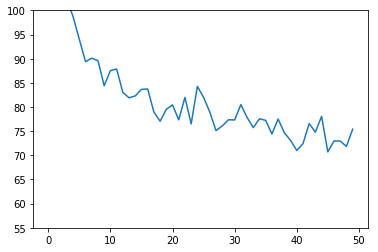

In [156]:
with tf.Session() as sess:
    ll = []
    sess.run(tf.global_variables_initializer())

    for i in range(50000):
        batch_ = data.next_batch(100)[0]
        batch_xs = batch_[:,0:392]
        batch_ys = batch_[:,392:784]

        _, ly = sess.run([train_step, loss], {x: batch_xs, y_: batch_ys})

        if i%1000==0:
            ll.append(ly)
            print i/1000, ly,

plt_figure(ll, 55, 100)

In [ ]:
alpha = 0.7
bl = tf.constant(0.0)
vr = tf.constant(0.0)

_bl = alpha*bl + (1.0-alpha)*loss
_vr = alpha*vr + (1.0-alpha)*tf.square(loss-_bl)
'''
ch1 = add_layer(sh1, 200, 100, tf.tanh)
cc1 = tf.reduce_mean(add_layer(ch1, 100, 1))
loss_c1 = tf.square(tf.stop_gradient(loss-_bl)-cc1)
train_c1 = tf.train.AdamOptimizer(lr).minimize(loss_c1)

ch2 = add_layer(sh2, 200, 100, tf.tanh)
cc2 = tf.reduce_mean(add_layer(ch2, 100, 1))
loss_c2 = tf.square(tf.stop_gradient(loss-_bl)-cc2)
train_c2 = tf.train.AdamOptimizer(lr).minimize(loss_c2)
'''
cc1=0.0
cc2=0.0
loss_c1 = 0.0
loss_c2 = 0.0

loss_h1 = tf.reduce_mean(tf.stop_gradient(
                         (loss-_bl-cc1)/tf.maximum(1.0,tf.sqrt(_vr))) * 
                         tf.log(sh1*h1+(1.0-sh1)*(1.0-h1)))
loss_h2 = tf.reduce_mean(tf.stop_gradient(
                         (loss-_bl-cc2)/tf.maximum(1.0,tf.sqrt(_vr))) * 
                         tf.log(sh2*h2+(1.0-sh2)*(1.0-h2)))

train_step = tf.train.AdamOptimizer(lr).minimize(loss+loss_h1+loss_h2+loss_c1+loss_c2)

In [ ]:
with tf.Session() as sess:
    ll = []
    bll = 0.0
    vrr= 0.0     
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(50000):
        batch_ = data.next_batch(100)[0]
        batch_xs = batch_[:,0:392]
        batch_ys = batch_[:,392:784]

        _, ly, bb, vv = sess.run([train_step, loss, _bl, _vr],
                                 {x: batch_xs, y_: batch_ys, bl: bll, vr: vrr})
        bll = bb
        vrr = vv
        
        if i%1000==0:
            ll.append(ly)
            print i/1000, ly,

### LR-C-VN lr=3e-4 alpha=0.7

In [ ]:
plt_figure(ll, 70, 100)

### LR-C-VN lr=1e-3 alpha=0.7

In [ ]:
plt_figure(ll, 70, 100)

### LR-C-VN-IDB

In [ ]:
plt_figure(ll, 70, 100)

In [ ]:
def LR(x, h1, sh1, h2, sh2, y, y_, loss):
    loss_h1 = tf.reduce_mean(tf.stop_gradient(loss) * tf.log(sh1*h1+(1.0-sh1)*(1.0-h1)))
    loss_h2 = tf.reduce_mean(tf.stop_gradient(loss) * tf.log(sh2*h2+(1.0-sh2)*(1.0-h2)))
    train_step = tf.train.AdamOptimizer(lr).minimize(loss+loss_h1+loss_h2+loss_c1+loss_c2)
    
    with tf.Session() as sess:
        ll = []
        sess.run(tf.global_variables_initializer())

        for i in range(50000):
            batch_ = data.next_batch(100)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            _, ly = sess.run([train_step, loss], {x: batch_xs, y_: batch_ys})

            if i%1000==0:
                ll.append(ly)
                print i/1000, ly,

    plt_figure(ll, 70, 100)

### LR

In [ ]:
plt_figure(ll, 70, 100)